In [1]:
import pandas as pd
from datetime import datetime
import numpy as np


users=pd.read_csv("takehome_users-intern.csv",encoding = "ISO-8859-1")
users_eng=pd.read_csv("takehome_user_engagement-intern.csv",encoding = "ISO-8859-1")

In [2]:
users_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


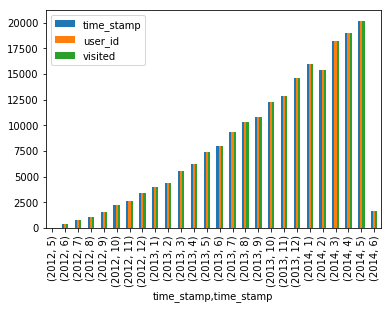

In [3]:

users_eng.time_stamp=pd.to_datetime(pd.Series(users_eng.time_stamp))
%matplotlib inline
users_eng.groupby([users_eng["time_stamp"].dt.year, users_eng["time_stamp"].dt.month]).count().plot(kind="bar")

#Based on the plot we can see the range of timelines are from May'2012 to June'2014. Also we see the number of rows keep increasing
# possibly becuase more and more users are using the platform

In [5]:
users_eng=users_eng.sort_values(by=["time_stamp"])
users_eng=users_eng.reset_index(drop=True)
users_eng.head()

,time_stamp,user_id,visited
0,2012-05-31 08:20:06,10012,1
1,2012-05-31 15:47:36,3428,1
2,2012-05-31 17:19:37,9899,1
3,2012-05-31 21:58:33,1693,1
4,2012-06-01 00:17:30,6102,1


In [6]:

def calculateYearMonthWeek(row):
    return(row['time_stamp'].strftime('%Y')+row['time_stamp'].strftime('%m')+row['time_stamp'].strftime('%U'))



users_eng['YearWeek']=users_eng.apply(calculateYearMonthWeek,axis=1)
users_eng['weekday']=users_eng.time_stamp.dt.weekday



In [7]:
users_eng.head()

,time_stamp,user_id,visited,YearWeek,weekday
0,2012-05-31 08:20:06,10012,1,20120522,3
1,2012-05-31 15:47:36,3428,1,20120522,3
2,2012-05-31 17:19:37,9899,1,20120522,3
3,2012-05-31 21:58:33,1693,1,20120522,3
4,2012-06-01 00:17:30,6102,1,20120622,4


In [9]:
## Calculating Acopted Users and appending it to the users dataframe
## First we group by 'year+month+week' and 'day of week' and get all user IDs for each group, Then we filter unique user IDs
## Then we group by 'year+month+week' so we get a 7-day period and count all the IDs who occured 3 or more times to get 
## adopted users
g=users_eng.groupby(['YearWeek','weekday'])['user_id'].apply(lambda x: list(set(x)))
g=g.to_frame().reset_index()
g=g.groupby('YearWeek')['user_id'].apply(lambda x: list(x))
g=g.to_frame()
g.head()


def filterAdopted(row):
   listf= [item for sublist in row['user_id'] for item in sublist]
   return([x for x in listf if listf.count(x)>=3])
   #print(fltr)
   #return(fl)
    
g['newuser']=g.apply(filterAdopted,axis=1)


adopted1=g['newuser'].apply(pd.Series).stack().unique()      
adopted1=list(map(int,adopted1))
adopted1[:10]
print(len(adopted1))

## After we get list of adopted users , we then append it to the users dataframe as a new column
## We get adopted users count as 1403
users['adopted']=users['object_id'].isin(adopted1)
users.head()

## We see below that the adopted column is appened to the users dataframe

1403


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,False


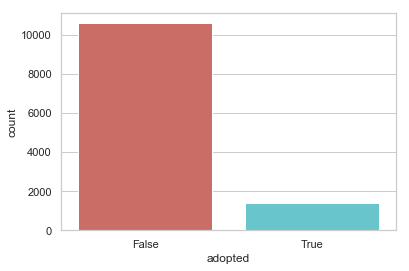

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


sns.countplot(x='adopted',data=users, palette='hls')
plt.show()

# We see that the classes(adopted and non-adopted) are imbalanced so we need to balance them both by over-sampling before fitting the model 

In [11]:
#Creating of training set- Processing of categorical values

# Creating One hot encoded columns for "Creation_Source" column since it a categorical column
 
users_train=users[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_by_user_id']]
dfDummies = pd.get_dummies(users_train['creation_source'], prefix = 'creatsrc')
users_train = pd.concat([users_train, dfDummies], axis=1)
users_train=users_train.drop(['creation_source', 'invited_by_user_id'], axis=1)
users_train.head()



,opted_in_to_mailing_list,enabled_for_marketing_drip,creatsrc_GUEST_INVITE,creatsrc_ORG_INVITE,creatsrc_PERSONAL_PROJECTS,creatsrc_SIGNUP,creatsrc_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


Text(0, 0.5, 'Proportion of ADopted and Non ADopted Users')

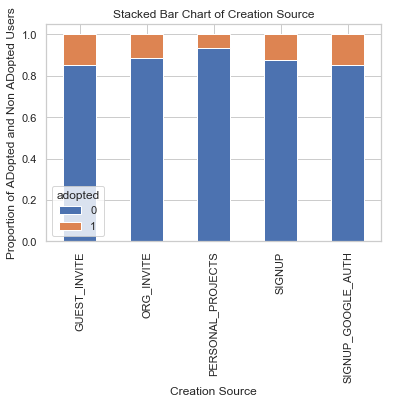

In [41]:
table=pd.crosstab(users.creation_source,users.adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Proportion of ADopted and Non ADopted Users')


In [12]:
# Creating One hot encoded columns for "Email Domain"
#Based on the distribution of the email domain as per the histogram chart created , we keep only the below email domain
# and categorise the remaining as Others
retainlist=['gmail.com','yahoo.com','jourrapide.com','cuvox.com','gustr.com','hotmail.com']

t=list(map(lambda x: str(x) if x in retainlist else 'Others',users.email_domain))
users['email_domain_new']=t
#users.email_domain_new.value_counts()
#users.email_domain_new.unique()

dfDummies1 = pd.get_dummies(users['email_domain_new'], prefix = 'email')
users_train = pd.concat([users_train, dfDummies1], axis=1)
#users_train=users_train.drop(['creation_source', 'invited_by_user_id'], axis=1)
users_train.head()


,opted_in_to_mailing_list,enabled_for_marketing_drip,creatsrc_GUEST_INVITE,creatsrc_ORG_INVITE,creatsrc_PERSONAL_PROJECTS,creatsrc_SIGNUP,creatsrc_SIGNUP_GOOGLE_AUTH,email_Others,email_gmail.com,email_gustr.com,email_hotmail.com,email_jourrapide.com,email_yahoo.com
0,1,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'Proportion of ADopted and Non ADopted Users')

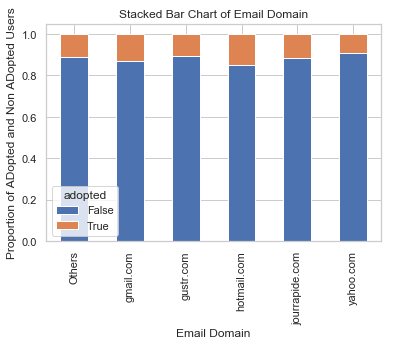

In [13]:
table=pd.crosstab(users.email_domain_new,users.adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Email Domain')
plt.xlabel('Email Domain')
plt.ylabel('Proportion of ADopted and Non ADopted Users')


## From the below plot, we can see that email domain can be a good indicator for identifying Adopted User

,opted_in_to_mailing_list,enabled_for_marketing_drip,creatsrc_GUEST_INVITE,creatsrc_ORG_INVITE,creatsrc_PERSONAL_PROJECTS,creatsrc_SIGNUP,creatsrc_SIGNUP_GOOGLE_AUTH,email_Others,email_gmail.com,email_gustr.com,...,email_jourrapide.com,email_yahoo.com,month_diff_0.0,month_diff_1.0,month_diff_2.0,month_diff_3.0,month_diff_4.0,month_diff_5.0,month_diff_6.0,month_diff_7-25
0,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


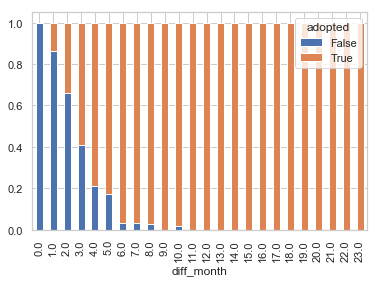

In [14]:
# creating a new column for time difference between accounted created time and last login time. As per analysis this seems to be a 
# good indicator for Adopted/Non-Adopted users

##however we are notsure if we can use engagement information for Adoption users prediction. so we develop two models 
## one with Engagement information and one without Engagement information

users.creation_time=pd.to_datetime(pd.Series(users.creation_time))
users['last_session_creation_time']=pd.to_datetime(users['last_session_creation_time'], unit='s')   
users.head()
users['diff_month'] = users['last_session_creation_time'] - users['creation_time']
users['diff_month']=(users['diff_month']/np.timedelta64(1,'M'))
users['diff_month'] =list(map(lambda x :int(x) if (not np.isnan(x)) else x,users['diff_month']))
users['diff_month']=users['diff_month'].fillna(0)
users.head()

users.groupby(['diff_month','adopted']).count()
table=pd.crosstab(users.diff_month,users.adopted)
table
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)


## Processing of diff_month column into categories.From the plot we identifying different bins to have difference between 
## creation time and last login tine into buckets 0,1,2,3,4,5,6,7-25

users['diff_month_cat'] = pd.cut(x=users['diff_month'], bins=[6,25], labels=['7-25'])
users['diff_month_cat'] = np.where(pd.isna(users['diff_month_cat']), users['diff_month'], users['diff_month_cat'])

# Creating dummy variables for the diff_month column using One Hot Encoding 

dfDummies_diff = pd.get_dummies(users['diff_month_cat'], prefix = 'month_diff')
dfDummies_diff
users_train = pd.concat([users_train, dfDummies_diff], axis=1)
users_train.head()




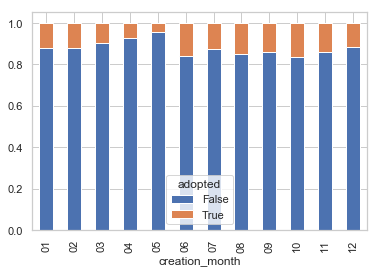

In [16]:
## Processing of Account Creation Month 

from datetime import datetime
users.creation_time=pd.to_datetime(pd.Series(users.creation_time))

def takeMonth(row):
    return(row['creation_time'].strftime('%m'))
users['creation_month']=users.apply(takeMonth,axis=1)
users.groupby(['creation_month','adopted']).count()

dfDummies_creation = pd.get_dummies(users['creation_month'], prefix = 'created_month')
dfDummies_creation
users_train = pd.concat([users_train, dfDummies_creation], axis=1)
users_train.head()


## From the graph below , we can use creation_month as an indicator for ADopted/Non-Adopted users
table=pd.crosstab(users.creation_month,users.adopted)
table
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

In [17]:
##Conversion of ADopted values which is True/False into 1/0

users['adopted']=users['adopted'].apply(lambda x: 1 if x == True else x)
users['adopted']=users['adopted'].apply(lambda x: 0 if x == False else x)
users['adopted'].value_counts()

0    10597
1     1403
Name: adopted, dtype: int64

In [18]:
users_train.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'creatsrc_GUEST_INVITE', 'creatsrc_ORG_INVITE',
       'creatsrc_PERSONAL_PROJECTS', 'creatsrc_SIGNUP',
       'creatsrc_SIGNUP_GOOGLE_AUTH', 'email_Others', 'email_gmail.com',
       'email_gustr.com', 'email_hotmail.com', 'email_jourrapide.com',
       'email_yahoo.com', 'month_diff_0.0', 'month_diff_1.0', 'month_diff_2.0',
       'month_diff_3.0', 'month_diff_4.0', 'month_diff_5.0', 'month_diff_6.0',
       'month_diff_7-25', 'created_month_01', 'created_month_02',
       'created_month_03', 'created_month_04', 'created_month_05',
       'created_month_06', 'created_month_07', 'created_month_08',
       'created_month_09', 'created_month_10', 'created_month_11',
       'created_month_12'],
      dtype='object')

In [19]:
##Correct the imbalanced classes in the target variable by up-sampling from the minority class
## using SMOTE algorithm(Synthetic Minority Oversampling Technique)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(users_train, users['adopted'], test_size=0.3, random_state=0)
columns = X_train.columns
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['adopted'])
#we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['adopted']==False]))
print("Number of subscription",len(os_data_y[os_data_y['adopted']==True]))
print("Proportion of 'No Adopted' Data in oversampled data is ",len(os_data_y[os_data_y['adopted']==False])/len(os_data_X))
print("Proportion of 'Adopted' data in oversampled data is ",len(os_data_y[os_data_y['adopted']==True])/len(os_data_X))

# We see that the propotions are equal and the upsampled data can now be used for Model Fitting


8400
3600
8400
3600
length of oversampled data is  14820
Number of no subscription in oversampled data 7410
Number of subscription 7410
Proportion of 'No Adopted' Data in oversampled data is  0.5
Proportion of 'Adopted' data in oversampled data is  0.5


In [20]:
# Recurisive Feature Eliminiation
# This is dont to identify important features by continoulsy fitting a model and then identifying best paramters


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

os_data_X.columns




C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

[False False False False False False False  True  True  True  True  True
  True  True  True  True  True False False False  True  True  True False
 False False  True  True  True  True  True  True  True]
[14 11  8  9  5  7  6  1  1  1  1  1  1  1  1  1  1 12 13 10  1  1  1  3
  4  2  1  1  1  1  1  1  1]


C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'creatsrc_GUEST_INVITE', 'creatsrc_ORG_INVITE',
       'creatsrc_PERSONAL_PROJECTS', 'creatsrc_SIGNUP',
       'creatsrc_SIGNUP_GOOGLE_AUTH', 'email_Others', 'email_gmail.com',
       'email_gustr.com', 'email_hotmail.com', 'email_jourrapide.com',
       'email_yahoo.com', 'month_diff_0.0', 'month_diff_1.0', 'month_diff_2.0',
       'month_diff_3.0', 'month_diff_4.0', 'month_diff_5.0', 'month_diff_6.0',
       'month_diff_7-25', 'created_month_01', 'created_month_02',
       'created_month_03', 'created_month_04', 'created_month_05',
       'created_month_06', 'created_month_07', 'created_month_08',
       'created_month_09', 'created_month_10', 'created_month_11',
       'created_month_12'],
      dtype='object')

In [21]:
import statsmodels.api as sm
logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.078801
         Iterations 11
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.886    
Dependent Variable:     adopted              AIC:                  2401.6635
Date:                   2019-09-22 21:21     BIC:                  2652.5867
No. Observations:       14820                Log-Likelihood:       -1167.8  
Df Model:               32                   LL-Null:              -10272.  
Df Residuals:           14787                LLR p-value:          0.0000   
Converged:              1.0000               Scale:                1.0000   
No. Iterations:         11.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
opte

In [22]:
## Takiing only column with p-value<=0.05


to_drop=['email_gustr.com','email_jourrapide.com','email_yahoo.com','month_diff_3.0','created_month_01','created_month_02','created_month_05','created_month_06','created_month_08','created_month_10','created_month_11','created_month_12']

In [26]:

os_data_X.columns
to_drop=['email_gustr.com','email_jourrapide.com','email_yahoo.com','month_diff_3.0','created_month_01','created_month_02','created_month_05','created_month_06','created_month_08','created_month_10','created_month_11','created_month_12']
os_data_X=os_data_X.drop(columns=to_drop,axis=1)
os_data_X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'creatsrc_GUEST_INVITE', 'creatsrc_ORG_INVITE',
       'creatsrc_PERSONAL_PROJECTS', 'creatsrc_SIGNUP',
       'creatsrc_SIGNUP_GOOGLE_AUTH', 'email_Others', 'email_gmail.com',
       'email_hotmail.com', 'month_diff_0.0', 'month_diff_1.0',
       'month_diff_2.0', 'month_diff_4.0', 'month_diff_5.0', 'month_diff_6.0',
       'month_diff_7-25', 'created_month_03', 'created_month_04',
       'created_month_07', 'created_month_09'],
      dtype='object')

In [27]:
## Logistic REgression

from sklearn.linear_model import LogisticRegression
from sklearn import metrics


X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os)
y_pred = logreg.predict(X_test_os)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_os, y_test_os)))


Accuracy of logistic regression classifier on test set: 0.97


C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_os, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test_os, y_pred))

[[2130   77]
 [  45 2194]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2207
           1       0.97      0.98      0.97      2239

    accuracy                           0.97      4446
   macro avg       0.97      0.97      0.97      4446
weighted avg       0.97      0.97      0.97      4446



In [29]:
from sklearn.metrics import r2_score
r2_score(y_test_os, y_pred)   

0.8902327302000841

In [31]:
#### We see that we are getting a very high accuracy mayb because you are using the Engagment data which is in the 
# column diff_month, so lets try to re-run the model by removing those columns
to_drop1=['month_diff_0.0', 'month_diff_1.0',
       'month_diff_2.0', 'month_diff_4.0', 'month_diff_5.0', 'month_diff_6.0',
       'month_diff_7-25']
os_data_X1=os_data_X.drop(columns=to_drop1,axis=1)
os_data_X1.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'creatsrc_GUEST_INVITE', 'creatsrc_ORG_INVITE',
       'creatsrc_PERSONAL_PROJECTS', 'creatsrc_SIGNUP',
       'creatsrc_SIGNUP_GOOGLE_AUTH', 'email_Others', 'email_gmail.com',
       'email_hotmail.com', 'created_month_03', 'created_month_04',
       'created_month_07', 'created_month_09'],
      dtype='object')

In [37]:
## Logistic REgression after remocing User Engagement Information



X_train_os1, X_test_os1, y_train_os1, y_test_os1 = train_test_split(os_data_X1, os_data_y, test_size=0.3, random_state=0)
logreg1 = LogisticRegression()
logreg1.fit(X_train_os1, y_train_os1)
y_pred1 = logreg1.predict(X_test_os1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg1.score(X_test_os1, y_test_os1)))

#confusion_matrix = confusion_matrix(y_test_os1, y_pred1)
#print(confusion_matrix)

print(classification_report(y_test_os1, y_pred1))
print(r2_score(y_test_os1, y_pred1) )


## After running this model we get an accuracy of 61% which has dropped because we have removed Engagement Information

Accuracy of logistic regression classifier on test set: 0.61
              precision    recall  f1-score   support

           0       0.62      0.55      0.59      2207
           1       0.60      0.67      0.63      2239

    accuracy                           0.61      4446
   macro avg       0.61      0.61      0.61      4446
weighted avg       0.61      0.61      0.61      4446

-0.5556361433119232


C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chintana\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
## After running this model we get an accuracy of 61% which has dropped because we have removed Engagement Information
## We use the coef_ paramter of Logistic REgression to identify the important features 
logreg1.coef_

array([[-0.38732274, -0.21193129, -2.84381129, -3.15058053, -4.12090583,
        -3.06935937, -2.9372517 , -0.29997962, -0.08981712,  0.20627002,
        -0.74383032, -0.9596971 , -0.08778914, -0.18035639]])

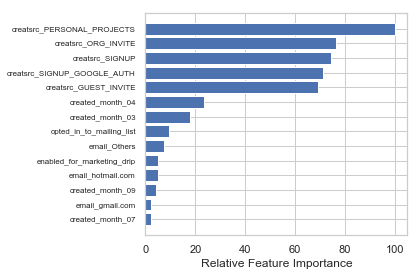

In [40]:
feature_importance = abs(logreg1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_os1.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

So based on the above graph we identify he most imporant paramters as below

1.) creation source with all 5 paramters encoded
2.) and if the account was created 'creation_time' in month 4 (April) and month 03 hich is March
3.) If the user is 'opted_in_mailing_list'

If we are able to use engagement information we can use the difference in time between account creation and last session creation column and use that in our model for more accuracy